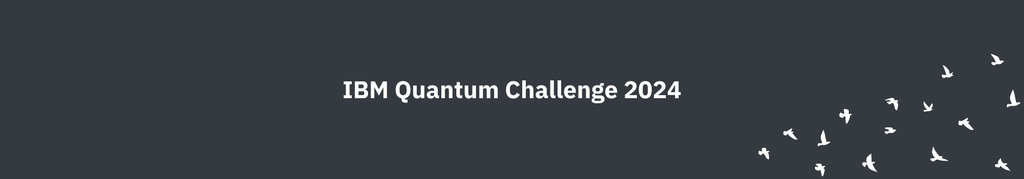

# Lab 4: Utility Scale Error Mitigation workflow with Qiskit Runtime Primitives

# Table of Contents
- **[Story -- Chapter 4](#Story---Chapter-4)**
- **[Background - ZNE and PEA for ZNE]()**
- **[Part 1: Utility Functions - Mapping the problem - 124Q x 15]()**
    - **[Exercise 1](#exercise1)**
    - **[Exercise 2](#exercise2)**
- **[Part 2: Transpilation: Converting to QISA]()**
    - **[Exercise 3](#exercise3)**
- **[Part 3: Execution modes and options: Optimizing and executing payload]()**
    - **[Exercise 4](#exercise4)**
    - **[Exercise 5](#exercise5)**
- **[Part 4: Postprocessing and visualizing results]()**
    - **[Exercise 6](#exercise6)**


In [ ]:
# For Testing purposes. Will remove for the final version

# This is required during testing phase. If you see the following error message:
# Failed: {'errors': [{'message': 'The challenge is not active', 'extensions': {'code': 'INVALID_QUERY'}}]}
# Restart the kernel and run this cell
%set_env QC_GRADE_ONLY=true

# If you see the following error message:
# Failed: Unable to access service (Forbidden)
# Uncomment the line below and copy and past your IBM Quantum token. See lab 0 for more detailed instructions
# %set_env QXToken=#your_token_here

## Background

### Motivation

The goal of this notebook is to give a demo of how to run a utility scale error mitigation experiment using Qiskit 1.0 through the Qiskit Runtime using an alpha version of *zero noise extrapolation* (ZNE) with *probabilistic error amplification* (PEA). The reference experiment and problem statement is based on **"Evidence for the utility of quantum computing before fault tolerance."** *Y. Kim et al.* [Nature 618.7965 (2023)](https://www.nature.com/articles/s41586-023-06096-3) ![Nature](https://learning-api.quantum.ibm.com/assets/824d04e5-27be-448c-bdf4-ebc71ec7d912)


In [1]:
#! pip install qiskit qiskit-aer qiskit-experiments qiskit-ibm-runtime

# Utility Scale Error Mitigation with Qiskit Runtime Primitives

## Background

### Zero-Noise Extrapolation (ZNE)

Zero-noise extrapolation (ZNE) is an error mitigation technique for removing the effects of an *unknown* noise during circuit execution that can be scaled in a *known* way. 

It assumes expectation values scale with noise by a known function

$$
\langle A(\lambda) \rangle = \langle A(0) \rangle =+ \sum_{k=0}^{m} a_k \lambda^k + R
$$
where $\lambda$ parameterizes the noise strength and can be *amplified*.

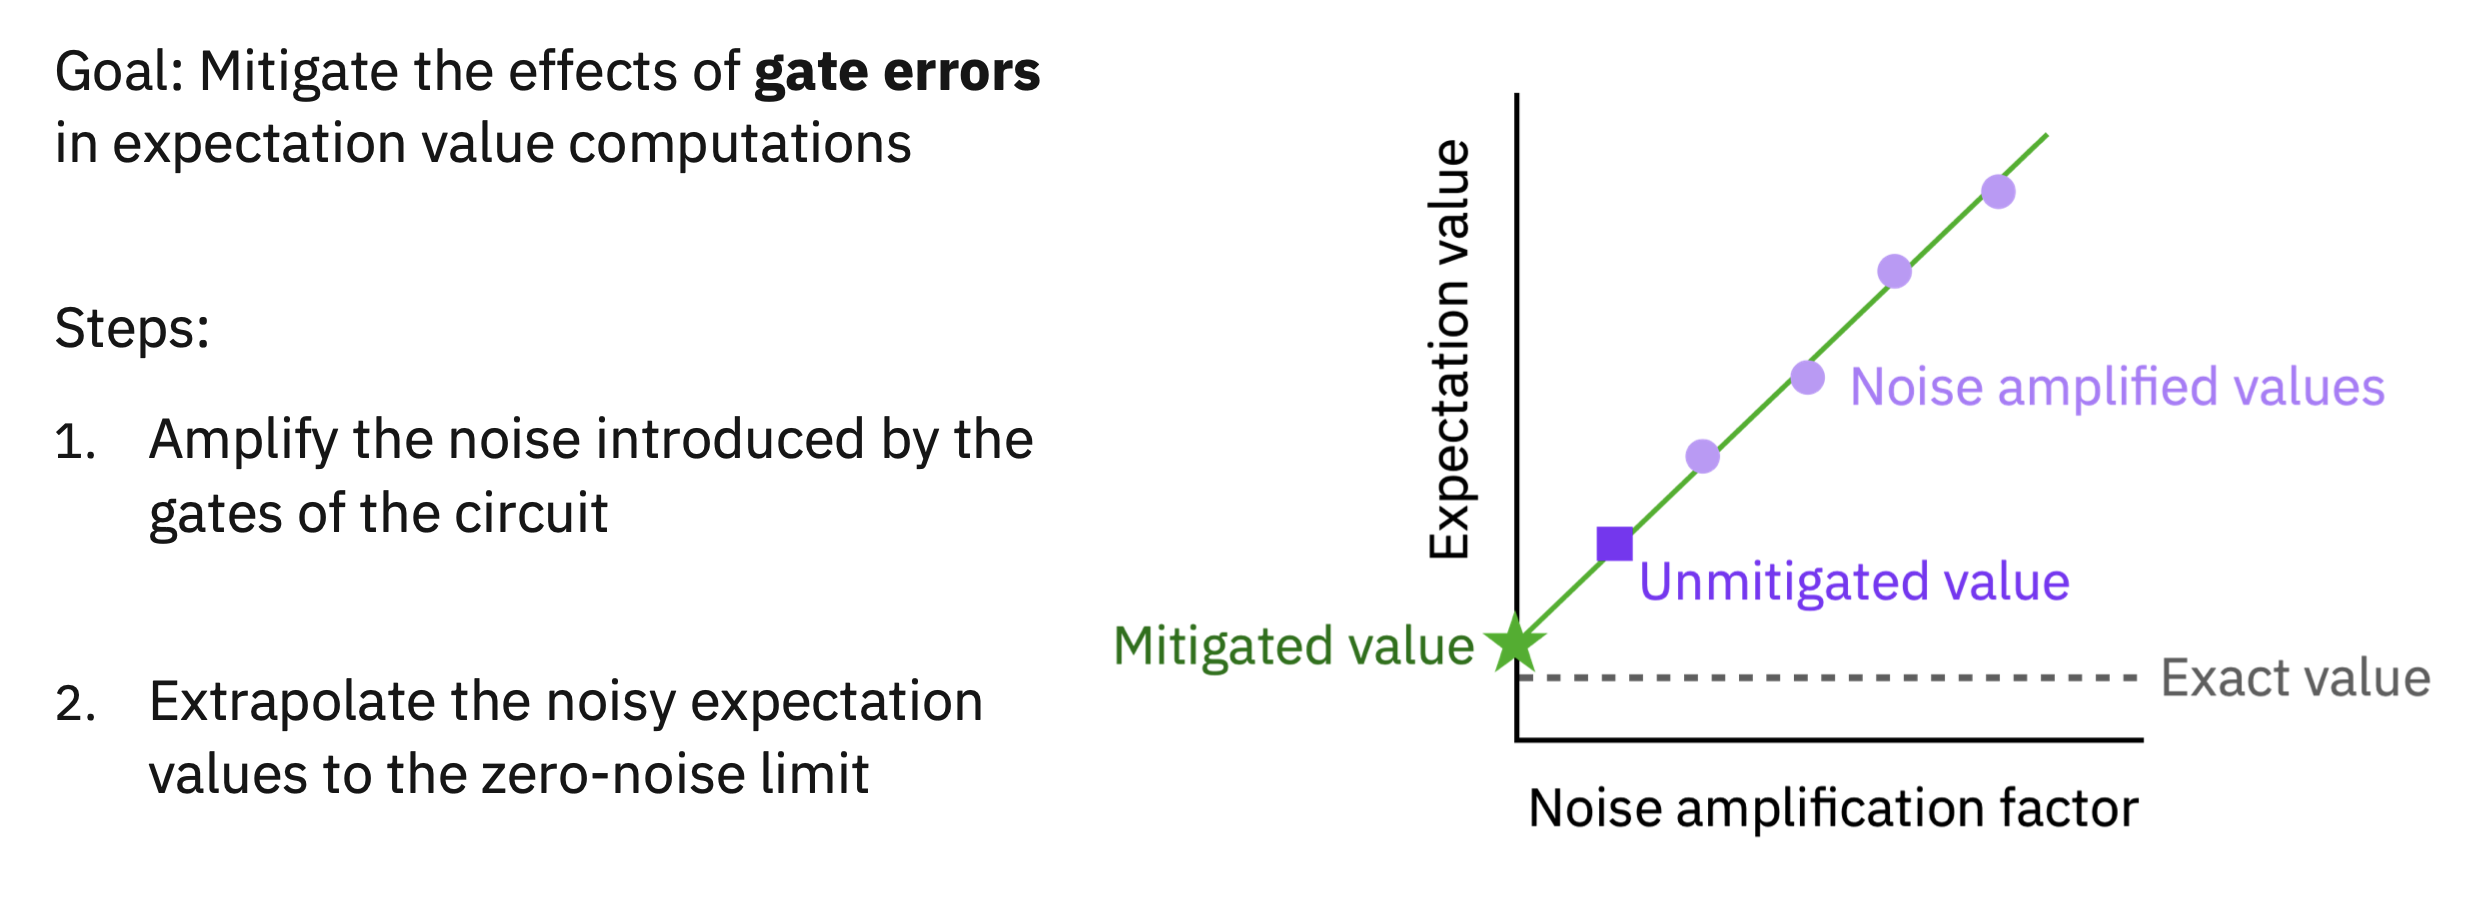

We can implement ZNE with the following steps:

1.  Amplify circuit noise for several noise factors $\lambda_1, \lambda_2, ... $
2.  Run every noise amplified circuit to measure $\langle A(\lambda_1)\rangle, ...$
3.  Extrapolate back to the zero noise limit $\langle A(0)\rangle$

![ZNE](https://learning-api.quantum.ibm.com/assets/a53cb99a-9769-4136-ae61-c7c757f77a83)


#### Amplifying noise for ZNE

The main challange in succesfully implementing ZNE is to have an accurate model for noise in the expectation value and to amplify the noise in a known way.

There are 3 common ways error amplification is implemented for ZNE.

| **Pulse Stretching** | **Gate Folding** | **Probabilistic Error Amplification** |
|-----------|-----------|-----------|
| Scale pulse duration via calibration | Repeat gates in identity cycles $U\mapsto U(U^{-1}U)^{\lambda-1}/2$ | Add noise via sampling Pauli channels |
| ![Pulse stretching](https://learning-api.quantum.ibm.com/assets/34feefd6-a65c-45f3-ac78-abaec4d4e049) | ![Gate folding](https://learning-api.quantum.ibm.com/assets/22125682-7a63-463f-bcb9-ab9ea6c8e8de) | ![PEA](https://learning-api.quantum.ibm.com/assets/1eaa7b06-5c02-4a32-9ce4-642b88f3009e) |
| Kandala et al. Nature (2019) | Shultz et al. PRA (2022) | Li & Benjamin PRX (2017) |


For utility scale experiments *probabilistic error amplification* (PEA) is the most attractive.
- Pulse stretching assumes gate noise is proportional to duration, which is typically not true. Calibration is also costly.
- Gate folding requires large stretch factors that greatly limit the depth of circuits that can be run.
- PEA can be applied to any circuit that can be run with native noise factor ($\lambda=1$) but requries learning the noise model.

#### Learning the noise model for PEA

PEA assumes the same layer-based noise model as *probabilistic error cancellation* (PEC) however it avoids the sampling overhead that scales exponential with the circuit noise.

__Reference__: E. van den Berg, Z. Minev, A. Kandala, and K. Temme, _Probabilistic error cancellation with sparse Pauli-Lindblad models on noisy quantum processors_ [arXiv:2201.09866](https://arxiv.org/abs/2201.09866)


| **Step 1** | **Step 2** | **Step 3** |
|-----------|-----------|-----------|
| Pauli twirl layers of 2-qubit gates | Repeat identity pairs of layers and learn the noise | Derive a fidelity (error for each noise channel) |
| ![PEC Twirling](https://learning-api.quantum.ibm.com/assets/aafb4506-3b2d-451f-8791-7ce6b2ee2fb8) | ![PEC Learn](https://learning-api.quantum.ibm.com/assets/0160e97e-2eb6-4d15-a799-2fcd41790098) | ![PEC Curve Fitting](https://learning-api.quantum.ibm.com/assets/decf5563-000d-4db4-b85a-4aeddaca7285)  |



### Extrapolation
This process was first carried out with a technique known as _Richardson extrapolation_. Nonetheless, we often use general regression methods to account for several different noise profiles and extrapolate the result back to get our value of interest


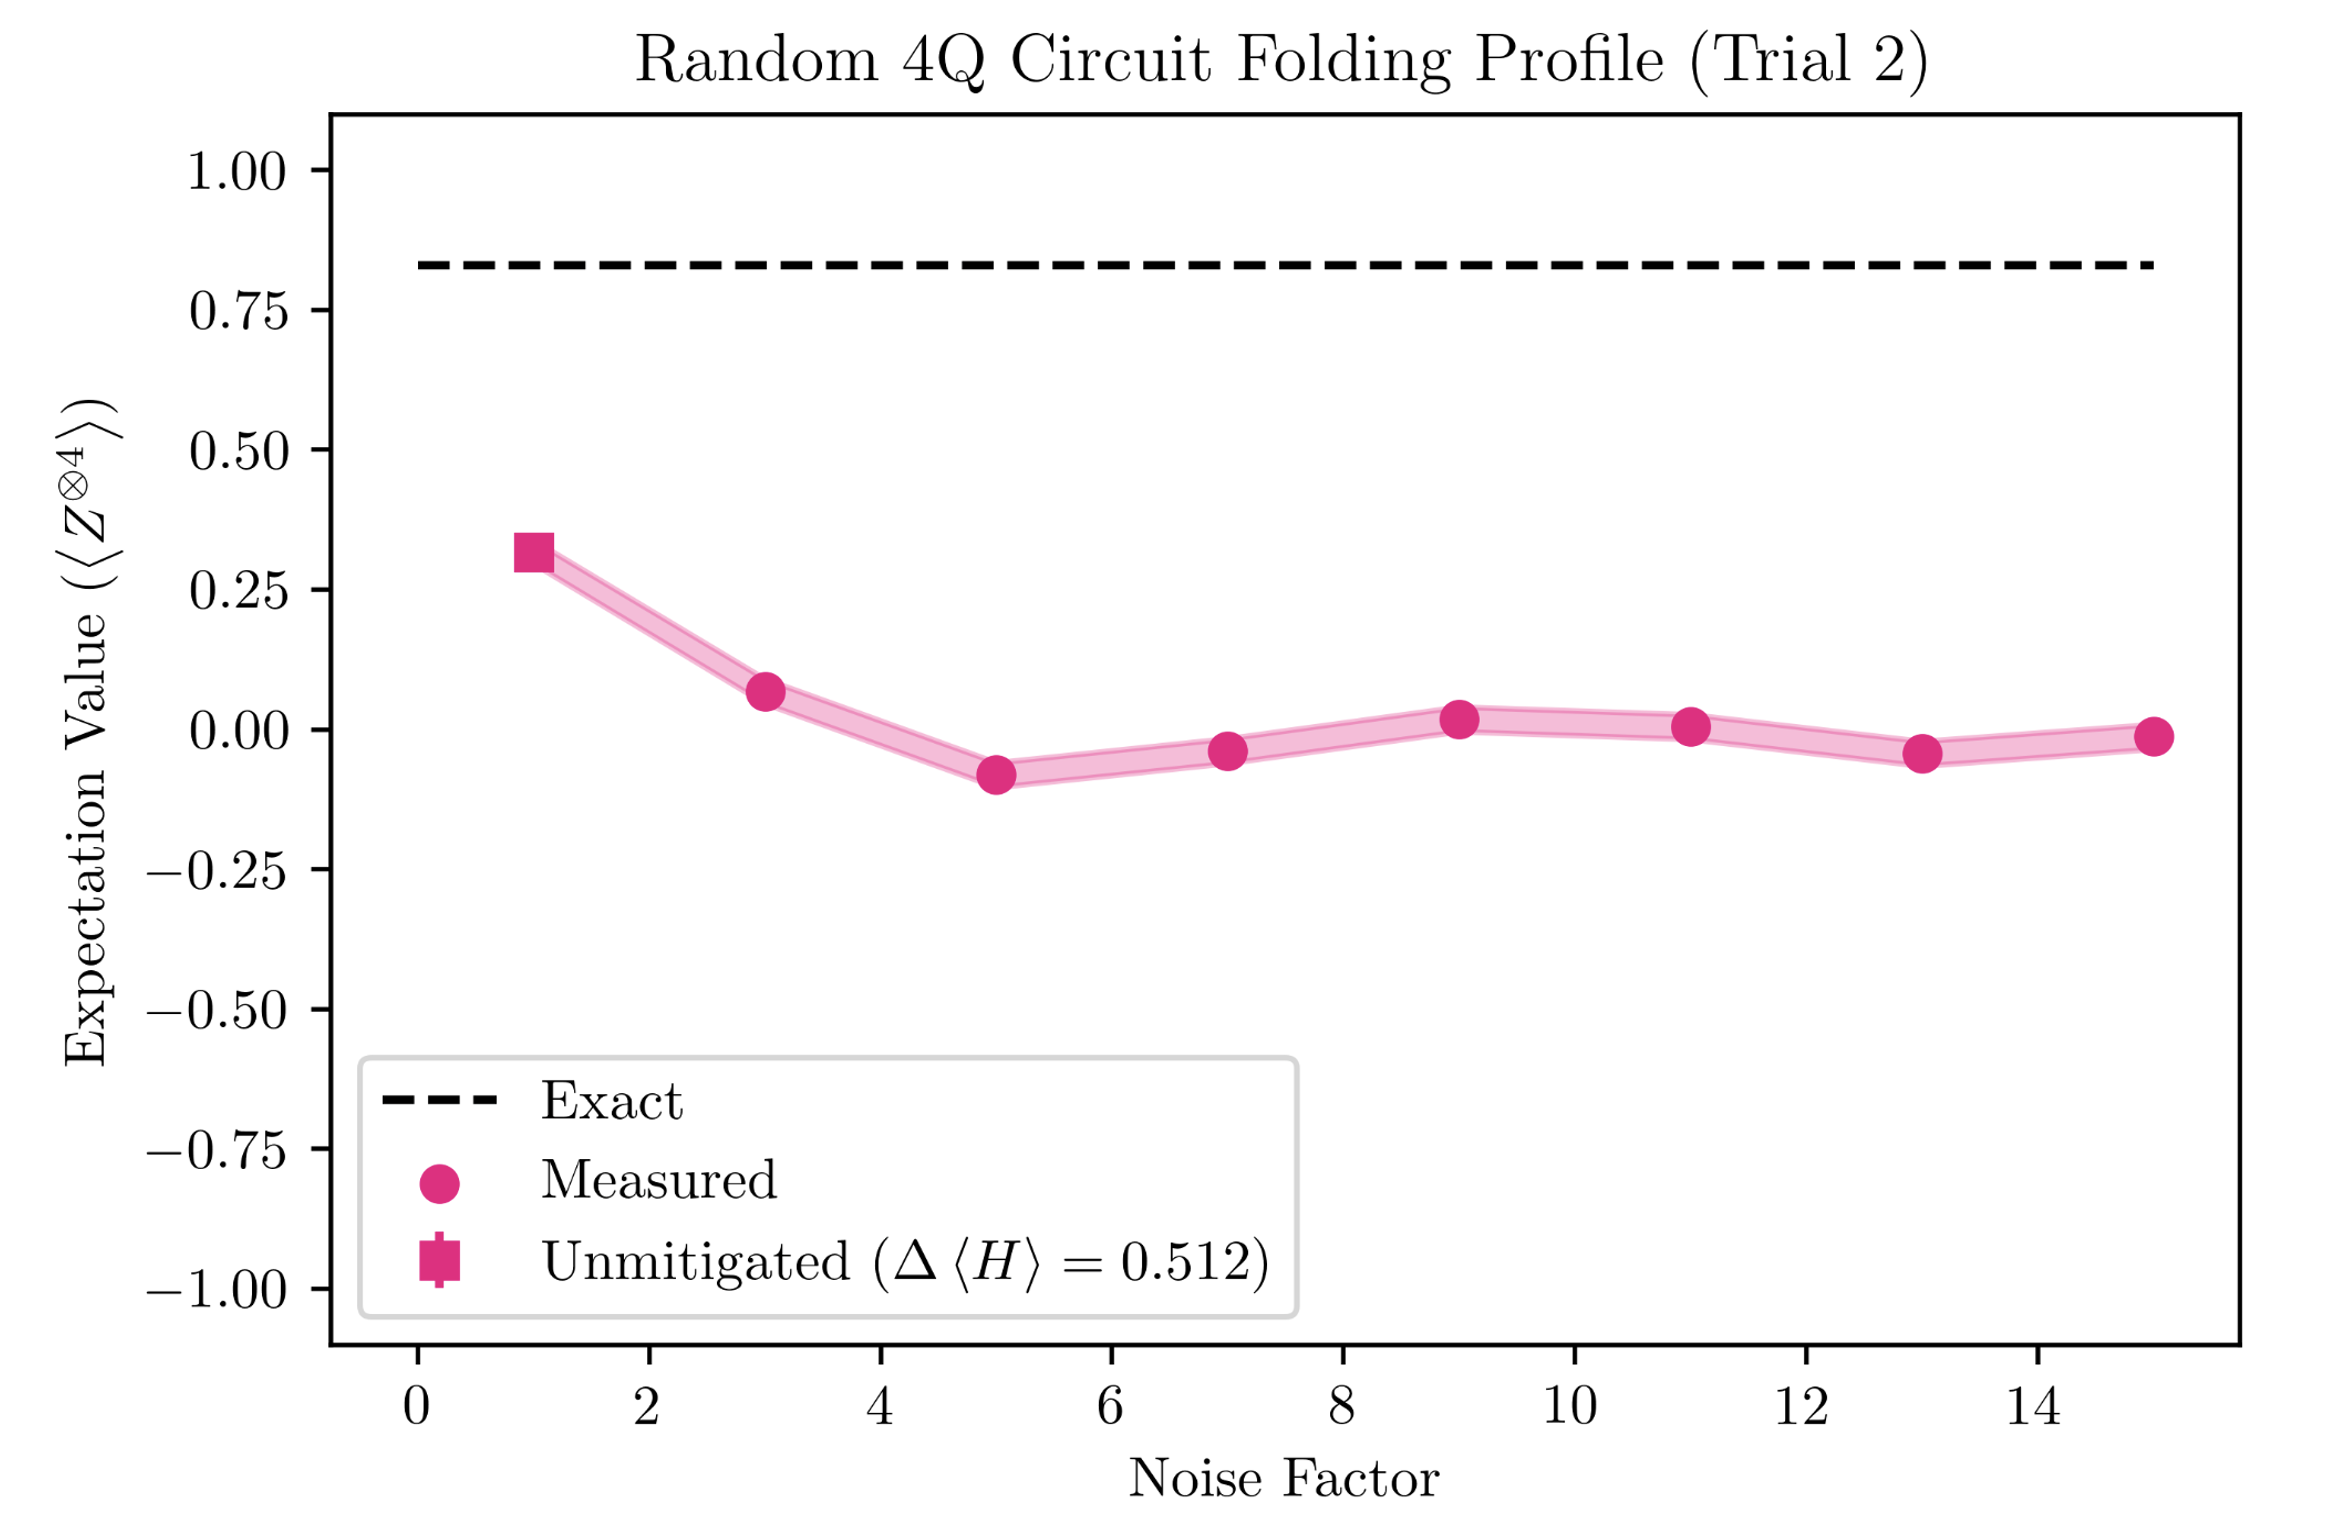

## Utility scale ZNE with the Qiskit Runtime

### Runtime and backend setup

#### Installation

We will now demonstrate how to run this experiment using the 0.23 release of the [Qiskit Runtime](https://github.com/Qiskit/qiskit-ibm-runtime/tree/experimental). Note this version requirese Qiskit 1.0 or above as well.

This branch exposes several experimental options to allow more fine grained configuration of error mitigation techniques which we will use to enable PEA. Note that all these options are experimental and subject to change before any official release.

#### Select a backend

First we choose a backend to run on. For this demonstration experiment were run using the 127-qubit IBM Kyiv backend. You should modify this to any backend you have available.

Note that for this experiment to be feasible the backend must support the new fast parametric update capabilities to enable execution of the large number of parameterized circuits for PEA. You can check if this is supported for a backend by seeing if `"parameters"` is in `backend.configuration().supported_features`.

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")

# Change to True to run a new experiment.
# If False this lets the entire notebook be re-run using saved data.
run_experiment = True

# Use a session when running experiment
use_session = True

In [11]:
# Load backend
backend = service.get_backend("ibm_brisbane")

# Check if parametric update is supported
fast_parametric_update = "parameters" in backend.configuration().supported_features
print("Parametric update supported:", fast_parametric_update)

Parametric update supported: True


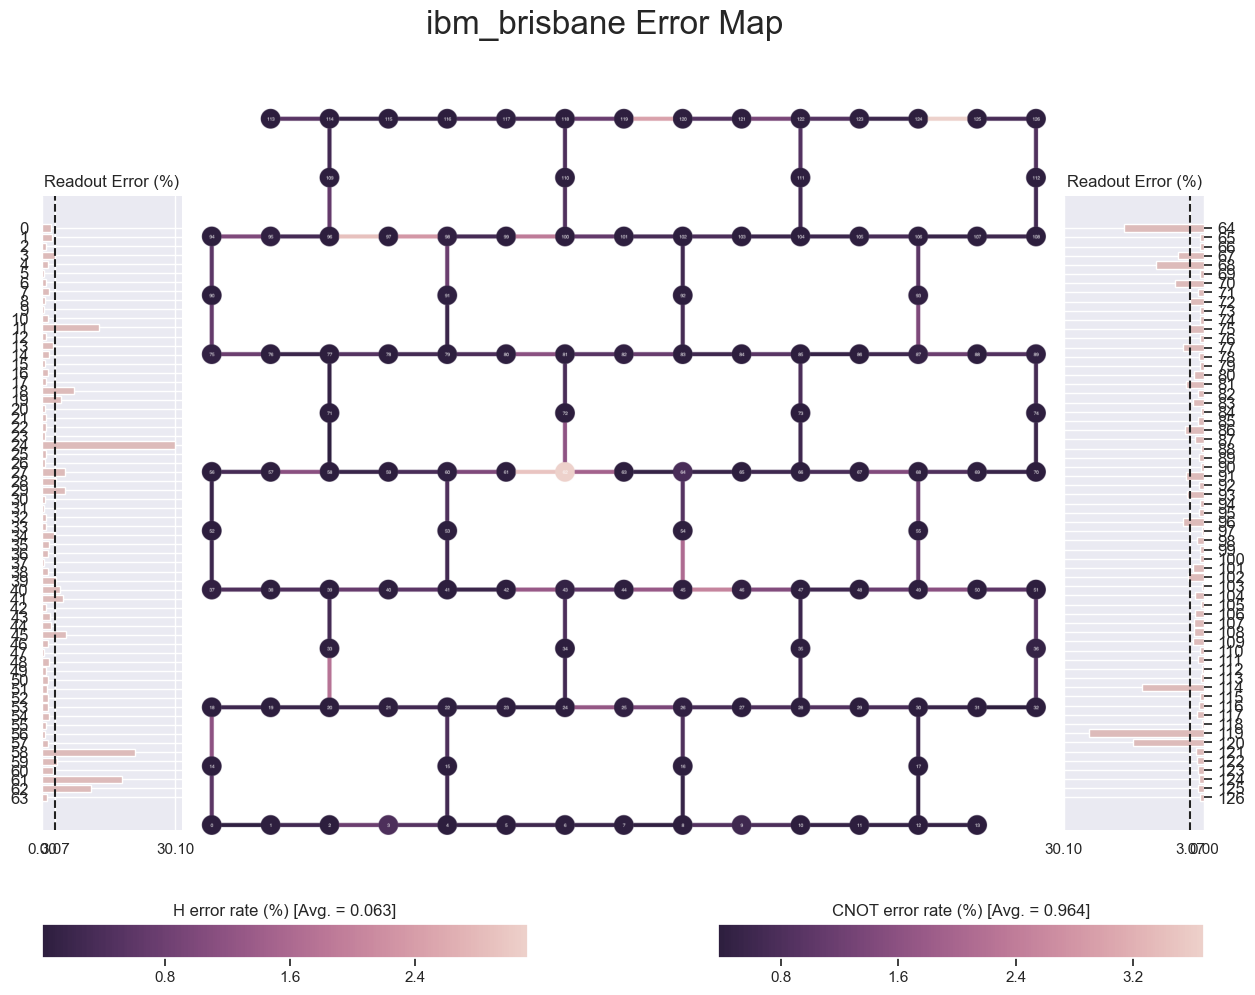

In [12]:
from qiskit.visualization import plot_error_map

# Plot gate error map to identify good and bad qubits
# NOTE: These can change over time so may differ in the returned figure than what is currently used in this notebook.
plot_error_map(backend)

# About the problem


## Why the Ising Model?

The Ising model is a mathematical model used in statistical mechanics and condensed matter physics to describe ferromagnetism in materials. It is one of the most studied models in physics due to its simplicity and the rich variety of phenomena it can describe. The Ising model is chosen for several reasons:

1. **Simplicity and Universality:**
   - Despite its simplicity, the Ising model captures essential features of phase transitions and critical phenomena, making it a powerful tool for understanding complex systems.
   
2. **Benchmarking Quantum Computers:**
   - The Ising model, particularly in higher dimensions and with transverse fields, poses computational challenges that classical computers struggle with, especially as system size grows. This makes it an excellent benchmark for testing the capabilities of quantum computers.

3. **Quantum Simulation:**
   - The Ising model can be mapped onto quantum circuits, allowing researchers to study quantum many-body phenomena and test quantum algorithms designed for quantum simulation.


## 2D Transverse-Field Ising Model

In the paper, the authors focus on the 2D transverse-field Ising model, which adds complexity and richness to the study due to the interplay between the interactions and the transverse field.

### Hamiltonian of the 2D Transverse-Field Ising Model

The Hamiltonian for the 2D transverse-field Ising model is:
\[ H = -J \sum_{\langle i, j \rangle} Z_i Z_j + h \sum_{i} X_i \]

where:

-  **J**  is the coupling constant between nearest-neighbor spins.
- **h** is the transverse field strength.
- \ **Z_i** \ and \( X_i \) are Pauli operators acting on spin \( i \).
- \\langle i, j \rangle\ denotes summation over nearest-neighbor pairs.
  
### Physical Interpretation

1. **Interaction Term (\( -J \sum_{\langle i, j \rangle} Z_i Z_j \)):**
   - This term represents the interaction between nearest-neighbor spins. For positive \( J \), the interaction is ferromagnetic, meaning neighboring spins prefer to align in the same direction.
   
2. **Transverse Field Term (\( h \sum_{i} X_i \)):**
   - This term represents the effect of a transverse magnetic field. It introduces quantum fluctuations by promoting spin flips, thereby competing with the interaction term.

### Quantum Phenomena and Challenges

1. **Phase Transitions:**
   - The model exhibits a quantum phase transition between a ferromagnetic phase (where spins align) and a paramagnetic phase (where spins are influenced by the transverse field) as the strength of the transverse field \( h \) is varied.

2. **Quantum Entanglement:**
   - The transverse-field Ising model generates significant quantum entanglement, especially near the critical point of the phase transition. This entanglement is challenging to simulate classically but can be naturally represented on a quantum computer.

3. **Computational Difficulty:**
   - As the system size increases, classical simulations of the 2D transverse-field Ising model become intractable due to the exponential growth of the Hilbert space.
     
## Implementation on Quantum Computers

The paper demonstrates the implementation of the 2D transverse-field Ising model on a 127-qubit quantum processor using Trotterization. This involves approximating the time evolution of the system by breaking it down into a sequence of simpler operations.

# Trotterization Overview

Trotterization is a method used to approximate the time evolution of a quantum system governed by a complex Hamiltonian by breaking it down into a sequence of simpler operations. This is particularly useful for quantum simulation on quantum computers.


## First-Order Trotter Decomposition

The time evolution operator \( U = e^{-iHt} \) for a small time step \( \delta t \) can be approximated using the Trotter-Suzuki formula:
\e^{-iH\delta t} \approx e^{-i ( -J \sum_{\langle i, j \rangle} Z_i Z_j ) \delta t} e^{-i ( h \sum_{i} X_i ) \delta t} \

This decomposition breaks down the complex time evolution into simpler, implementable steps:

- \e^{-i ( h \sum_{i} X_i ) \delta t} \: This represents single-qubit rotations about the \X \-axis.
- \e^{-i ( -J \sum_{\langle i, j \rangle} Z_i Z_j  \delta t} \: This represents two-qubit interactions, which can be implemented using \(R_{ZZ}\) rotations.


[Nature 618.7965 (2023)](https://www.nature.com/articles/s41586-023-06096-3) ![Nature](https://learning-api.quantum.ibm.com/assets/824d04e5-27be-448c-bdf4-ebc71ec7d912)

## Quantum Circuit for 127-Qubit Lattice

In the experimental setup, the 127 qubits are arranged in a heavy-hex lattice topology, and the interactions are implemented using layers of \( R_{ZZ} \) gates. The circuit for one Trotter step can be visualized as follows:

1. **Apply \R_X(\theta_h)\** rotations to all qubits.
2. **Apply \R_{ZZ}(\theta_J)\** rotations to all pairs of neighboring qubits, which are parallelized in layers to fit the hardware connectivity.


To cover all nearest-neighbor interactions in the heavy-hex lattice, the \( ZZ \) interactions are divided into three layers. Each layer targets a specific set of qubit pairs to ensure all necessary interactions are covered without overlap within a single layer.

### Layer Breakdown

- **Layer 1: Horizontal Interactions**
- **Layer 2: Diagonal Interactions (Top-Left to Bottom-Right)**
- **Layer 3: Diagonal Interactions (Top-Right to Bottom-Left)**

### Detailed Breakdown

#### Layer 1: Horizontal Interactions
This layer involves \ZZ\ interactions between qubits that are horizontally adjacent. In the heavy-hex lattice, these interactions occur between qubits connected directly along the rows.

#### Layer 2: Diagonal Interactions (Top-Left to Bottom-Right)
This layer involves \ZZ\ interactions between qubits that are diagonally adjacent from the top-left to the bottom-right. In the heavy-hex lattice, these interactions occur between qubits that are one step down and to the right.

#### Layer 3: Diagonal Interactions (Top-Right to Bottom-Left)
This layer involves \ZZ\ interactions between qubits that are diagonally adjacent from the top-right to the bottom-left. In the heavy-hex lattice, these interactions occur between qubits that are one step down and to the left.


## Exercise 1: Describing Entangling layer and creating entangling function

In [ ]:
"""Trotter circuit generation"""

from __future__ import annotations
from collections.abc import Sequence
from collections import defaultdict
from math import inf
import numpy as np
import networkx as nx
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import CXGate, CZGate, ECRGate
from qiskit.providers import Backend
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.quantum_info import PauliList


def remove_qubit_couplings(
    couplings: Sequence[tuple[int, int]], qubits: Sequence[int] | None = None
) -> list[tuple[int, int]]:
    """Remove qubits from a coupling list.

    Args:
        couplings: A sequence of qubit couplings.
        qubits: Optional, the qubits to remove.

    Returns:
        The input couplings with the specified qubits removed.
    """
    if qubits is None:
        return couplings
    qubits = set(qubits)
    return [edge for edge in couplings if not qubits.intersection(edge)]


def coupling_qubits(
    *couplings: Sequence[tuple[int, int]], allowed_qubits: Sequence[int] | None = None
) -> list[int]:
    """Return a sorted list of all qubits involved in 1 or more couplings lists.

    Args:
        couplings: 1 or more coupling lists.
        allowed_qubits: Optional, the allowed qubits to include. If None all
            qubits are allowed.

    Returns:
        The intersection of all qubits in the couplings and the allowed qubits.
    """
    qubits = set()
    for edges in couplings:
        for edge in edges:
            qubits.update(edge)
    if allowed_qubits is not None:
        qubits = qubits.intersection(allowed_qubits)
    return list(qubits)


def directed_coupling_map(backend: Backend) -> CouplingMap:
    """Construct a single-directional coupling map of shortest gates.

    Args:
        backend: A backend to extract coupling map and gate durations from.

    Returns:
        The directed coupling map of the shortest gate for each coupling pair.
    """
    directional_coupling = {}
    target = backend.target
    durations = target.durations()
    for inst, qubits in target.instructions:
        if inst.num_qubits == 2 and qubits is not None:
            key = tuple(sorted(qubits))
            if key in directional_coupling:
                continue
            q0, q1 = key
            try:
                length1 = durations.get(inst, (q0, q1))
            except TranspilerError:
                length1 = inf
            try:
                length2 = durations.get(inst, (q1, q0))
            except TranspilerError:
                length2 = inf

            shortest_pair = [q0, q1] if length1 <= length2 else [q1, q0]
            directional_coupling[key] = shortest_pair
    return CouplingMap(sorted(directional_coupling.values()))


def construct_layer_couplings(backend: Backend) -> list[list[tuple[int, int]]]:
    """Separate a coupling map into disjoint 2-qubit gate layers.

    Args:
        backend: A backend to construct layer couplings for.

    Returns:
        A list of disjoint layers of directed couplings for the input coupling map.
    """
    # Convert coupling map to a networkx graph
    coupling_graph = nx.Graph(list(directed_coupling_map(backend)))

    # Edge coloring is vertex coloring on the dual graph
    dual_graph = nx.line_graph(coupling_graph)
    edge_coloring = nx.greedy_color(dual_graph, interchange=True)

    # Sort layers
    layers = defaultdict(list)
    for edge, color in edge_coloring.items():
        layers[color].append(edge)
    layers = [sorted(layers[i]) for i in sorted(layers.keys())]

    return layers



In [ ]:
from lab4 import grade_lab4_ex1

grade_lab4_ex1(construct_layer_couplings([0,1,2,3,4,5,6,7,8]) ##Check against list for specific inputs

## Circuit Utils


## Implementing the Trotter Steps

Each Trotter step consists of a layer of single-qubit \( R_X \) rotations followed by layers of two-qubit \( R_{ZZ} \) rotations. For a large 127-qubit lattice, the implementation requires efficient parallelization to handle the interactions between neighboring qubits.

### Single-Qubit Rotations

The single-qubit rotations are implemented as:
\[ R_X(\theta_h) = e^{-i \theta_h X} \]
where \( \theta_h = h \delta t \).

### Two-Qubit ZZ Rotations

The two-qubit interactions are implemented as:
\[ R_{ZZ}(\theta_J) = e^{-i \theta_J Z_i Z_j} \]
where \( \theta_J = 2J \delta t \).



Each step includes single-qubit \( R_X \) rotations and two-qubit \( R_{ZZ} \) rotations. Random Pauli gates are inserted to "twirl" and controllably scale the noise of each CNOT layer. The dagger symbol (†) indicates conjugation by the ideal layer.

- **Single-Qubit \( R_X \) Rotations:** These rotations are applied to all qubits and correspond to the transverse field term in the Hamiltonian.
- **Two-Qubit \( R_{ZZ} \) Rotations:** These rotations implement the interaction between neighboring qubits.
- **Random Pauli Twirling:** This technique helps in characterizing and mitigating noise by averaging out certain types of errors.


In [13]:
def entangling_layer(
    gate_2q: str,
    couplings: Sequence[tuple[int, int]],
    qubits: Sequence[int] | None = None,
) -> QuantumCircuit:
    """Generating a entangling layer for the specified couplings.

    This corresonds to a Trotter layer for a ZZ Ising term with angle Pi/2.

    Args:
        gate_2q: The 2-qubit basis gate for the layer, should be "cx", "cz", or "ecr".
        couplings: A sequence of qubit couplings to add CX gates to.
        qubits: Optional, the physical qubits for the layer. Any couplings involving
            qubits not in this list will be removed. If None the range up to the largest
            qubit in the couplings will be used.

    Returns:
        The QuantumCircuit for the entangling layer.
    """
    # Get qubits and convert to set to order
    if qubits is None:
        qubits = range(1 + max(coupling_qubits(couplings)))
    qubits = set(qubits)

    # Mapping of physical qubit to virtual qubit
    qubit_mapping = {q: i for i, q in enumerate(qubits)}

    # Convert couplings to indices for virtual qubits
    indices = [
        [qubit_mapping[i] for i in edge]
        for edge in couplings
        if qubits.issuperset(edge)
    ]

    # Layer circuit on virtual qubits
    circuit = QuantumCircuit(len(qubits))

    # Get 2-qubit basis gate and pre and post rotation circuits
    gate2q = None
    pre = QuantumCircuit(2)
    post = QuantumCircuit(2)

    if gate_2q == "cx":
        gate2q = CXGate()
        # Pre-rotation
        pre.sdg(0)
        pre.z(1)
        pre.sx(1)
        pre.s(1)
        # Post-rotation
        post.sdg(1)
        post.sxdg(1)
        post.s(1)
    elif gate_2q == "ecr":
        gate2q = ECRGate()
        # Pre-rotation
        pre.z(0)
        pre.s(1)
        pre.sx(1)
        pre.s(1)
        # Post-rotation
        post.x(0)
        post.sdg(1)
        post.sxdg(1)
        post.s(1)
    elif gate_2q == "cz":
        gate2q = CZGate()
        # Identity pre-rotation
        # Post-rotation
        post.sdg([0, 1])
    else:
        raise ValueError(
            f"Invalid 2-qubit basis gate {gate_2q}, should be 'cx', 'cz', or 'ecr'"
        )

    # Add 1Q pre-rotations
    for inds in indices:
        circuit.compose(pre, qubits=inds, inplace=True)

    # Use barriers around 2-qubit basis gate to specify a layer for PEA noise learning
    circuit.barrier()
    for inds in indices:
        circuit.append(gate2q, (inds[0], inds[1]))
    circuit.barrier()

    # Add 1Q post-rotations after barrier
    for inds in indices:
        circuit.compose(post, qubits=inds, inplace=True)

    # Add physical qubits as metadata
    circuit.metadata["physical_qubits"] = tuple(qubits)

    return circuit


def trotter_circuit(
    theta: Parameter | float,
    layer_couplings: Sequence[Sequence[tuple[int, int]]],
    num_steps: int,
    gate_2q: str | None = "cx",
    backend: Backend | None = None,
    qubits: Sequence[int] | None = None,
) -> QuantumCircuit:
    """Generate a Trotter circuit for the 2D Ising

    Args:
        theta: The angle parameter for X.
        layer_couplings: A list of couplings for each entangling layer.
        num_steps: the number of Trotter steps.
        gate_2q: The 2-qubit basis gate to use in entangling layers.
            Can be "cx", "cz", "ecr", or None if a backend is provided.
        backend: A backend to get the 2-qubit basis gate from, if provided
            will override the basis_gate field.
        qubits: Optional, the allowed physical qubits to truncate the
            couplings to. If None the range up to the largest
            qubit in the couplings will be used.

    Returns:
        The Trotter circuit.
    """
    if backend is not None:
        try:
            basis_gates = backend.configuration().basis_gates
        except AttributeError:
            basis_gates = backend.basis_gates
        for gate in ["cx", "cz", "ecr"]:
            if gate in basis_gates:
                gate_2q = gate
                break

    # If no qubits, get the largest qubit from all layers and
    # sepecify the range so the same one is used for all layers.
    if qubits is None:
        qubits = range(1 + max(coupling_qubits(layer_couplings)))

    # Generate the entangling layers
    layers = [
        entangling_layer(gate_2q, couplings, qubits=qubits)
        for couplings in layer_couplings
    ]

    # Construct the circuit for a single Trotter step
    num_qubits = len(qubits)
    trotter_step = QuantumCircuit(num_qubits)
    trotter_step.rx(theta, range(num_qubits))
    for layer in layers:
        trotter_step.compose(layer, range(num_qubits), inplace=True)

    # Construct the circuit for the specified number of Trotter steps
    circuit = QuantumCircuit(num_qubits)
    for _ in range(num_steps):
        circuit.rx(theta, range(num_qubits))
        for layer in layers:
            circuit.compose(layer, range(num_qubits), inplace=True)

    circuit.metadata["physical_qubits"] = tuple(qubits)
    return circuit


def magnetization_observables(
    physical_qubits: Sequence[int], num_qubits: int | None = None
) -> PauliList:
    """Return the PauliList for magnetization measurement observables for ISA circuits."""
    max_qubit = max(physical_qubits)
    if num_qubits is None:
        num_qubits = 1 + max_qubit
    elif num_qubits <= max_qubit:
        raise ValueError(
            f"num_qubits must be >= {max_qubit} for specified physical qubits"
        )
    zs = np.zeros((len(physical_qubits), num_qubits), dtype=bool)
    for idx, qubit in enumerate(physical_qubits):
        zs[idx, qubit] = True
    xs = np.zeros_like(zs)
    return PauliList.from_symplectic(zs, xs)

In [ ]:
from lab4 import grade_lab4_ex2

grade_lab4_ex2(trotter_circuit, magnetization_observables) ##Check for QuantumCircuit and PauliList types

## File Utils

In [14]:
"""Saving and loading utility functions"""

from __future__ import annotations
import json

from qiskit_ibm_runtime import RuntimeDecoder, RuntimeEncoder


def save_json(obj: any, filename: str):
    """Save Python object to a JSON file"""
    with open(filename, "w", encoding="utf-8") as file:
        json.dump(obj, file, cls=RuntimeEncoder, indent=4)
    print(f"JSON saved to: {filename}")


def load_json(filename: str) -> any:
    """Load JSON from a file"""
    with open(filename, "r", encoding="utf-8") as file:
        data = json.load(file, cls=RuntimeDecoder)
    return data

## Visualization Utils

In [15]:
"""Result visualization functions"""

from __future__ import annotations
from collections.abc import Sequence
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from qiskit.primitives import PubResult

# For plot style
seaborn.set()


def plot_trotter_results(
    pub_result: PubResult,
    angles: Sequence[float],
    plot_raw: bool = True,
    plot_all: bool = True,
    exact: np.ndarray = None,
    close: bool = True,
):
    """Plot average magnetization from ZNE result data.

    Args:
        pub_result: an Estimator PubResult obtained from this notebook.
        angles: The Rx angle values for the experiment.
        plot_raw: If True include the unextrapolated raw data curves in the plot.
        plot_all: If True plot all extrapolators, if False only plot the Automatic method.
        exact: Optional, the exact values to include in the plot. Should be a 2D numpy array.
            where the first column is theta angle values, and the second column average magnetization.
        close: Close the Matplotlib figure before returning.

    Returns:
        The figure.
    """
    values = np.asarray(pub_result.data.evs, dtype=float)
    metadata = pub_result.metadata
    num_qubits = values.shape[0]
    num_params = values.shape[1]

    angles = np.asarray(angles).ravel()
    if angles.shape != (num_params,):
        raise ValueError(
            f"Incorrect number of angles for input data {angles.size} != {num_params}"
        )

    # Get extrapolators from metadata
    # Note that the first entry is the automatic method so we skip it
    extraps = np.asarray(metadata["resilience"]["zne_extrapolator"], dtype=object)
    zne_methods = ["Automatic"] + list(extraps[0, 0, 1:, 0])

    # Get raw data noise factors from metadata
    noise_factors = np.asarray(metadata["resilience"]["zne_noise_factors"], dtype=float)
    raw_nfs = noise_factors[0, 0, 1, extraps[0, 0, 1] == None]
    zne_idx = np.arange(noise_factors.shape[-1])[noise_factors[0, 0, 1] == 0][0]

    # Take average magnetization of qubits and its standard error
    y_vals = np.mean(values, axis=0)
    y_errs = np.std(values, axis=0) / np.sqrt(num_qubits)
    x_vals = angles / np.pi

    fig, _ = plt.subplots(1, 1)
    # Plot different extrapolation methods
    for i, method in enumerate(zne_methods):
        fmt = "o-" if method == "Automatic" else "s-."
        alpha = 1 if method == "Automatic" else 0.5
        if plot_all or method == "Automatic":
            label = f"ZNE ({method})" if plot_all else "ZNE"
            plt.errorbar(
                x_vals,
                y_vals[:, i, zne_idx],
                y_errs[:, i, zne_idx],
                fmt=fmt,
                alpha=alpha,
                label=label,
            )

    # Plot raw data
    if plot_raw:
        for i, nf in enumerate(raw_nfs):
            idx = i - len(raw_nfs)
            plt.errorbar(
                x_vals,
                y_vals[:, 0, idx],
                y_errs[:, 0, idx],
                fmt="d:",
                alpha=0.5,
                label=f"Raw (nf={nf:.1f})",
            )

    # Plot exact data
    if exact is not None:
        x_exact, y_exact = exact.T
        x_exact = x_exact / np.pi
        plt.plot(x_exact, y_exact, "--", color="black", alpha=0.5, label="Exact")

    plt.ylim(0, 1.25)
    plt.xlabel("θ/π")
    plt.ylabel(r"$\overline{\langle Z \rangle}$")
    plt.legend()
    plt.title(f"Error Mitigated Average Magnetization for Rx(θ) [{num_qubits}-qubit]")
    if close:
        plt.close(fig)
    return fig


def plot_qubit_zne_data(
    pub_result: PubResult,
    angles: Sequence[float],
    qubit: int,
    num_cols: int | None = None,
    close: bool = True,
):
    """Plot ZNE extrapolation data for specific virtual qubit

    Args:
        pub_result: The Estimator PubResult for the PEA experiment.
        angles: The Rx theta angles used for the experiment.
        qubit: The virtual qubit index to plot.
        num_cols: The number of columns for the generated subplots.
        close: Close the Matplotlib figure before returning.

    Returns:
        The Matplotlib figure.
    """
    values = np.asarray(pub_result.data.evs, dtype=float)
    stderrs = np.asarray(pub_result.data.stds, dtype=float)
    metadata = pub_result.metadata
    num_params = values.shape[1]

    angles = np.asarray(angles).ravel()
    if angles.shape != (num_params,):
        raise ValueError(
            f"Incorrect number of angles for input data {angles.size} != {num_params}"
        )

    # Get extrapolators from metadata
    # Note that the first entry is the automatic method so we skip it
    extraps = np.asarray(metadata["resilience"]["zne_extrapolator"], dtype=object)[
        qubit
    ]
    zne_methods = ["Automatic"] + list(extraps[0, 1:, 0])

    # Get raw data noise factors from metadata
    noise_factors = np.asarray(
        metadata["resilience"]["zne_noise_factors"], dtype=float
    )[qubit]
    raw_idx = extraps[0, 1] == None
    zne_idx = extraps[0, 1] != None

    raw_x = noise_factors[0, 2, raw_idx]
    raw_y = values[qubit, 0, 0, raw_idx]

    # Make a square subplot
    num_cols = num_cols or int(np.ceil(np.sqrt(num_params)))
    num_rows = int(np.ceil(num_params / num_cols))
    fig, axes = plt.subplots(
        num_rows, num_cols, sharex=True, sharey=True, figsize=(12, 5)
    )
    fig.suptitle(f"ZNE data for virtual qubit {qubit}")

    for pidx, ax in zip(range(num_params), axes.flat):
        for i, method in enumerate(zne_methods):
            zne_x = noise_factors[pidx, i, zne_idx]
            zne_y = values[qubit, pidx, i, zne_idx]
            zne_yerr = stderrs[qubit, pidx, i, zne_idx]
            ax.errorbar(
                zne_x, zne_y, zne_yerr, fmt="s:", alpha=0.5, label=f"PEA ({method})"
            )

        raw_x = noise_factors[pidx, 1, raw_idx]
        raw_y = values[qubit, pidx, 1, raw_idx]
        raw_yerr = stderrs[qubit, pidx, 1, raw_idx]
        ax.errorbar(raw_x, raw_y, yerr=raw_yerr, fmt="o", label="Raw")

        ax.set_ylim(0, 1.2)
        ax.set_yticks([0, 0.5, 1])
        ax.set_xticks([0, 1, 1.6])
        ax.set_title(f"θ/π = {angles[pidx]/np.pi:.2f}")
        if pidx == 0:
            ax.set_ylabel(rf"$\langle Z_{{{qubit}}} \rangle$")
        if pidx == num_params - 1:
            ax.set_xlabel("Noise Factor")
            ax.legend()
    if close:
        plt.close(fig)
    return fig

#### Define entangling layer couplings

To implement the Trotterized Ising simulation from the paper we define 3 layers of CX couplings for our device, which will be repeated at each Trotter steps. These define the 3 twirled layers we will need to learn the noise for to implement mitigation.

In [18]:
# Define entangling layers for the backends coupling map
layer_couplings = construct_layer_couplings(backend)
for i, layer in enumerate(layer_couplings):
    print(f"Layer {i}:\n{layer}\n")

Layer 0:
[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (12, 17), (14, 18), (15, 22), (16, 26), (19, 20), (24, 34), (27, 28), (30, 31), (32, 36), (33, 39), (37, 38), (40, 41), (43, 44), (45, 54), (47, 46), (48, 49), (51, 50), (52, 56), (53, 60), (57, 58), (61, 62), (64, 63), (65, 66), (68, 67), (69, 70), (71, 77), (73, 85), (74, 89), (75, 90), (78, 79), (80, 81), (83, 92), (86, 87), (91, 98), (93, 106), (94, 95), (96, 97), (99, 100), (102, 101), (103, 104), (107, 108), (109, 114), (110, 118), (111, 122), (112, 126), (116, 117), (119, 120), (123, 124)]

Layer 1:
[(1, 0), (2, 3), (4, 15), (6, 7), (8, 9), (11, 12), (17, 30), (18, 19), (20, 33), (22, 21), (23, 24), (26, 25), (28, 29), (31, 32), (34, 43), (35, 47), (36, 51), (37, 52), (39, 38), (41, 42), (45, 46), (49, 55), (56, 57), (58, 59), (60, 61), (62, 72), (64, 65), (66, 67), (68, 69), (70, 74), (76, 77), (79, 80), (81, 82), (83, 84), (85, 86), (87, 88), (90, 94), (96, 109), (98, 99), (100, 110), (102, 103), (104, 111), (106, 105), (108, 

We also remove the following bad qubits from our Trotterized Ising simulation. We will look at the coupling map for this backend so we can see if any qubits are experiencing TLS errors and remove them from our experiment.

In [19]:
# Remove bad qubits from layers
bad_qubits = {62, 119} # qubits removed based on high error coupling (1.00)
good_qubits = list(set(range(backend.num_qubits)).difference(bad_qubits))
print("Physical qubits:\n", good_qubits)

Physical qubits:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126]


In [ ]:
from lab4 import grade_lab4_ex3

grade_lab4_ex3(good_qubits, layer_couplings) ##Check for lists

### Construct the Estimator inputs and options

#### Circuit Generation

Next we define a utility function `trotter_circuit` that constructs the trotter circuit defined in terms of the above coupling layers for a fixed number of trotter steps. We will simulate with 6 trotter steps, which is equal to 18 layers of 2-qubit gates (either CX or ECR depending on the backend).

Note that when we are doing PEA experiments using the `Estimator` to minimize the number of unique layers of twirled 2-qubit gates for noise model learning it is best to work with the intended 2-qubit basis gate and layout directly. We use barriers between our 3 entangling layers of 2-qubit gates to deparate them and ensure they will be treated as such, and we use the `initial_layout` tranpsiler option to make sure the virtual qubits in our layers are mapped to the correct physical qubits for the couplng.

In [20]:
%%time
import numpy as np
from qiskit import transpile
from qiskit.circuit import Parameter

# Construct Trotter circuit
num_steps = 6
theta = Parameter("theta")
circuit = trotter_circuit(theta, layer_couplings, num_steps, qubits=good_qubits, backend=backend)
isa_circuit = transpile(circuit, backend=backend, initial_layout=good_qubits, layout_method="trivial", optimization_level=1)

CPU times: user 2.49 s, sys: 85.5 ms, total: 2.57 s
Wall time: 2.68 s


In [21]:
isa_circuit.draw("mpl", fold=-1)

#### Defining parameter values and Observables

We wish to measure the magentization.

In [22]:
# Construct theta parameters to measure
num_params = 12

# 12 parameter values for Rx between [0, pi/2].
# Reshape to outer product broadcast with obesrvables
parameter_values = np.linspace(0, np.pi/2, num_params).reshape((num_params, 1))
parameter_values = parameter_values[[0,1,2,3,4,5,-1]]
num_params = parameter_values.size

In [23]:
# Construct magnetization observables
# We reshape to broadcast with parameter values so each qubit
# magnetization is measured for each thea values
isa_observables = [[i] for i in magnetization_observables(good_qubits, isa_circuit.num_qubits)]

# Construct EstimatorPub
pub = (isa_circuit, isa_observables, parameter_values)

In [ ]:
from lab4 import grade_lab4_ex4

grade_lab4_ex4(isa_circuit, isa_observables) ##Check for QuantumCircuit and PauliList

In [24]:
print(isa_observables)

[[Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...')], [Pauli('I

# Preliminaries

Recall that a depolarizing error with probability $p$ on $n$ qubits can be defined by the map

$E_p(ρ) = (1 - p) ρ + p \text{Tr}[ρ] \frac{I}{2^n}$

For numerical examples, we will use $p = 1/10$.

Let's first take a look at the `depolarizing_error` function provided by the `noise` module in `qiskit-aer`.

In [2]:
from qiskit_aer.noise import depolarizing_error

dep_err = depolarizing_error(param=0.1, num_qubits=1)

dep_err

QuantumError([(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1182ca960>, 0.925), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x118309eb0>, 0.025), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1182f98e0>, 0.025), (<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11832bad0>, 0.025)])

The depolarizing error is returned as a `QuantumError` object.

Depending on the context, it may be more useful to view a `QuantumError` object as a [super operator](https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.quantum_info.SuperOp) 

In [3]:
dep_err.to_quantumchannel()

SuperOp([[0.95+0.j, 0.  +0.j, 0.  +0.j, 0.05+0.j],
         [0.  +0.j, 0.9 +0.j, 0.  +0.j, 0.  +0.j],
         [0.  +0.j, 0.  +0.j, 0.9 +0.j, 0.  +0.j],
         [0.05+0.j, 0.  +0.j, 0.  +0.j, 0.95+0.j]],
        input_dims=(2,), output_dims=(2,))

Or [Pauli Transfer Matrix (PTM)](https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.quantum_info.PTM).

In [4]:
from qiskit.quantum_info import PTM
PTM(dep_err.to_quantumchannel())

PTM([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
     [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
     [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
     [0. +0.j, 0. +0.j, 0. +0.j, 0.9+0.j]],
    input_dims=(2,), output_dims=(2,))

Now suppose every time we apply an `X` gate to a qubit, a depolarizing error is applied immediately after.

Ideally, after an even number of applications of the `X` gate the channel should be the identity.

Let's record the [process fidelity](https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.quantum_info.process_fidelity) each time and see what happens.

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import process_fidelity, SuperOp

qc = QuantumCircuit(1)
fids = []
for i in range(32):
    fids.append(process_fidelity(SuperOp(qc)))
    for _ in range(2):
        qc.x(0)
        qc.append(dep_err, (0,))

If we then plot the process fidelity as a function of the number of applications, we see an exponential decay.

Text(0, 0.5, 'Process Fidelity w/ Identity')

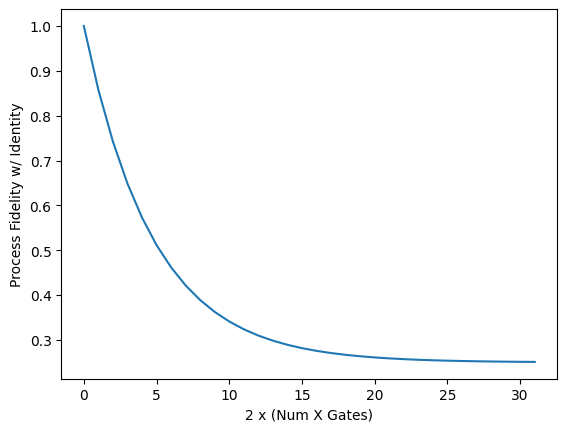

In [6]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(fids)
ax.set_xlabel("2 x (Num X Gates)")
ax.set_ylabel("Process Fidelity w/ Identity")

In this plot we can see something important happening: The error in the circuit (measured here by the process fidelity) accumulates as we increase the number of `X` gates. In fact, the decay here is exponential. This observation is important because the idea that errors accumulate with additional gates underlies both
- [Zero Noise Extrapolation (error mitigation technique)](https://www.google.com/search?client=firefox-b-1-d&q=zne+quantum+error+mitigation) and 
- [Randomized Benchmarking (characterization protocol)](https://qiskit-extensions.github.io/qiskit-experiments/manuals/verification/randomized_benchmarking.html)
- among many other methods in the characterization of noise on quantum processors.

Now that we seen a few tools to explore sources of error, let's dig a little deeper.

# Exercise: T1 Characterization

## Problem Statement

Your goal for this exercise is the following:

Given access to a device (in this case, a simulator for `ibm_kyiv`) **produce the Pauli Transfer Matrix**
- acting on the `0`th qubit
- which corresponds to the error due to $T_1$ relaxation
- for a gate lasting 500ns
- assuming $T_1 = T_2$

Do this using the [`qiskit-experiments` T1 characterization experiment](https://qiskit-extensions.github.io/qiskit-experiments/stubs/qiskit_experiments.library.characterization.T1.html#qiskit_experiments.library.characterization.T1).

In [7]:
from qiskit_ibm_runtime.fake_provider import FakeKyiv
backend = FakeKyiv()

In [8]:
# Here are some assorted hints
import numpy as np
physical_qubits = (0,)
delays = 1e-6 * np.linspace(0, 1000, num=20)
from qiskit_experiments.library import T1
from qiskit_aer.noise import thermal_relaxation_error

In [9]:
# Your work goes here!

In [10]:
# Check your results!
#validate_exercise_t1_characterization(
#    backend=backend, # Should just be FakeKyiv()
#    exp_data=exp_data, # Exp Data from T1 experiment
#    t1_ptm=t1_ptm, # The PTM you found for the T1 channel
#)

In [ ]:
from lab4 import grade_lab4_ex5

grade_lab4_ex5(validate_exercise_t1_characterization(
   backend=backend, # Should just be FakeKyiv()
   exp_data=exp_data, # Exp Data from T1 experiment
   t1_ptm=t1_ptm, # The PTM you found for the T1 channel

# Exercise: Zero Noise Extrapolation

In the previous exercise you used `qiskit-experiments` to characterize noise and extract information about the device.

Now let's try to use our understanding of device noise to come up with some rudimentary heuristic for determining if some given set of ZNE stretch factors are feasible.

The circuit that we'll use is mostly arbitrary. We'll just prepare a Bell state and apply the inverse circuit repeatedly until we reach the desired number of gates. Ideally, the qubits should always be in the ground state in the end.

In [ ]:
num_qubits = 3
target_depth = 50

In [20]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import PauliList, Clifford

qc = QuantumCircuit(num_qubits)

# Pick a random Clifford circuit
qc.h(range(num_qubits))
for i in range(num_qubits-1):
    qc.cx(i, i+1)
qc.barrier()
qc.compose(qc.inverse(), inplace=True)
qc.barrier()

# Repeat it until the desired depth
while qc.depth() <= target_depth:
    qc.compose(qc, inplace=True)

qc.measure_all()

To simulate our noise stretching, we'll take the circuit from before and simulate it assuming a variable gate time, which changes according to some stretch factor. The default values for the parameters here were taken from `ibm_kyiv`. In the end, we'll compute the fraction of the population which ends up in the all `0` state (which is the ideal case).

In [21]:
from qiskit_aer.noise import thermal_relaxation_error
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator

def simulate_stretched_ev(
    stretch_factor: float,
    t1: float = 272e-6,
    t2: float = 100e-6,
    gate_time: float = 561e-9,
):

    noise_model = NoiseModel()
    t1_err = thermal_relaxation_error(
        t1=t1,
        t2=t2,
        time=gate_time * stretch_factor,
    )
    t1_err = t1_err.tensor(t1_err)
    noise_model.add_all_qubit_quantum_error(t1_err, "cx")
    aer_simulator = AerSimulator(noise_model=noise_model)


    result = aer_simulator.run(qc, shots=8192).result()

    cts = result.data()["counts"]

    return cts.get("0x0", 0) / sum(cts.values())

Now we can plot the population in the ground state as a function of our stretch factor. Unsurprisingly, the fraction of the population in the ideal state drops as the stretch factor increases. Conversely, a stretch factor of `0` puts all the population in the ideal state.

Text(0.5, 0, 'ZNE Stretch Factor')

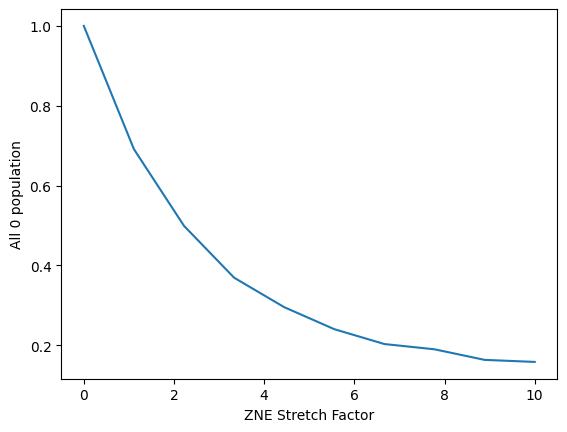

In [26]:
import matplotlib.pyplot as plt
ax = plt.gca()

stretch_factors = list(np.linspace(0, 10, num=10))
evs = list(map(simulate_stretched_ev, stretch_factors))

ax.plot(stretch_factors, evs)
ax.set_ylabel("All 0 population")
ax.set_xlabel("ZNE Stretch Factor")

There's something important to note here. Some sets of stretch factors on the plot above don't have much useful information we can use for extrapolation.

More concretely, the amplified error rates have washed out our signal, so if we tried to use stretch factors of 6, 8, and 10 in the above plot, we would probably get a bad result when trying to extrapolate back to 0.

## Problem Statement

Finally, we can state the problem. We'd like to come up with some sort of heuristic to determine at what circuit depth is the above setup going to give unreliable results. Suppose our stretch factors are $x=1,2,3$ and the ideal function that we're trying to fit is $f(x)$ with $f(0) = 1$.

Suppose our heuristic is the following: If $\text{Var}(\left[ f(1), f(2), f(3) \right]) < \delta^*$ for some $\delta^* > 0$, we'll say the extrapolation is infeasible.

The question that we would like to answer is: If $\delta^* = 0.01$, what is the largest possible circuit (in terms of depth) we would consider feasible?

For simplicity we'll assume that our circuit always has 3 qubits. Round your answer **down** to the nearest multiple of 20.

In [27]:
# Your work goes here!

stretch_factors = [1, 2, 3]
evs = list(map(simulate_stretched_ev, stretch_factors))
delta = 0.01

print(f"Circuit depth was: {qc.depth()}")

np.var(evs)

Circuit depth was: 97


0.016349265972773235

In [ ]:
from lab4 import grade_lab4_ex6

grade_lab4_ex6(validate_exercise_zne(max_feasible_circuit_depth=180))

## Setup using Qiskit Runtime: Configure Estimator options


Next we configure the `Estimator` options needed to run our mitigation experiment. This includes options for the noise learning of the entangling layers, and for ZNE extrapolation.

The configuration we will use is as follows

In [53]:
# Experiment options
max_pubs_per_batch_job = 20
num_randomizations = 700
num_randomizations_learning = 40
shots_per_randomization = 64
learning_pair_depths = [0, 1, 2, 4, 6, 12, 24]
noise_factors = [1, 1.3, 1.6]

# Base option formatting
options = {
    # Builtin resilience settings for ZNE
    "path":"ibm_kyiv_240311_1719",
    "resilience": {
        "measure_mitigation": True,
        "zne_mitigation": True,
        "zne": {"noise_factors": noise_factors},

        # TREX noise learning configuration
        "measure_noise_learning": {
            "num_randomizations": num_randomizations_learning,
            "shots_per_randomization": 1024,
        },
        
        # PEA noise model configuration
        "layer_noise_learning": {
            "max_layers_to_learn": 3,
            "layer_pair_depths": learning_pair_depths,
            "shots_per_randomization": shots_per_randomization,
            "num_randomizations": num_randomizations_learning,
        },
    },
    
    # Randomization configuration
    "twirling": {
        "num_randomizations": num_randomizations,
        "shots_per_randomization": shots_per_randomization,
        "strategy": "active-circuit",
    },
    
    # Optionally enable DD (note this currently seems to make things worse)
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },

    # Experimental settings for PEA method
    "experimental": {
        # Just in case, disable any further qiskit transpilation not related to twirling / DD
        "skip_transpilation": True,

        # Execution configuration
        "execution": {
            "max_pubs_per_batch_job": max_pubs_per_batch_job,
            "fast_parametric_update": True,
        },

        # Error Mitigation configuration
        "resilience": {
            # ZNE Configuration
            "zne": {
                "amplifier": "pea",
                "noise_factors": noise_factors,
                "return_all_extrapolated": True,
                "return_unextrapolated": True,
                "extrapolated_noise_factors": [0, 0.25, 0.5, 0.75],
            }
        }
    }
}

In [ ]:
from lab4 import grade_lab4_ex7

grade_lab4_ex7(options) ##Check for dictionary

#### Explanation of experimental ZNE options

We give a brief explanation of what these additional options available in the experimental branch do. Note that these options and names are not finalized and everything here is subject to change before an official release.

* __amplifier__: The method to use when amplifying noise to the intended noise factors.
    Allowed values are `"gate_folding"` which amplifies by repeating 2-qubit basis gates,
    and `"pea"` which amplifies by probabilistic sampling after learning the Pauli-twirled
    noise model for layers of twirled 2-qubit basis gates.
* __return_all_extrapolated__: If True return an array of the extrapolated expectation values
    for all input ``zne_extrapolator`` models, along with the automatically selected
    extrapolated value. If False only return the automatically selected extrapolated value.
* __return_unextrapolated__: If True return the unextrapolated expectation values for each
    of ihe input ``zne_noise_factors`` along with the extrapolated values as an array
    valued result. If False only return the extrapolated values.
* __extrapolated_noise_factors__: Specify 1 or more noise factor values to evaluate the
    extrapolated models at. If a sequence of values the returned results will be array
    valued with specified noise factor evaluated for the extrapolation model. A value
    of 0 corresponds to zero-noise extrapolation.

### Initialize the Estimator and run the experiment

Next we run our experiment on the Estimator. This can be done either using a session or not. Note that if you run with a session you block everyone else from using the device until the experiment finishes.

In [54]:
from qiskit_ibm_runtime import EstimatorV2, Session
from utils import RetrieverEstimatorV2
# Initialize estimator
use_session = True
if use_session:
    session = Session(backend=backend)
    
    estimator = RetrieverEstimatorV2(session=session, options=options)
else:
    estimator = EstimatorV2(backend=backend, options=options)

RetrieverEstimatorV2 - for IBM Quantum Challenge 2024


In [55]:
# Run job
if run_experiment:
    job = estimator.run([pub])
    print(job)

  Done! [==============================] 100%
These are pre-run results from a previous quantum system run

Loading results from json... Done! [==============================] 100%
Storing results... Done! [==============================] 100%

Results loaded! 
PubResult(data=DataBin(evs=np.ndarray(<shape=(125, 12, 3, 10), dtype=float64>), stds=np.ndarray(<shape=(125, 12, 3, 10), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(125, 12, 3, 10), dtype=float64>)), metadata={'shots': 44800, 'target_precision': 0.015625, 'circuit_metadata': {'physical_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,

This 127-qubit experiment with the settings in this notebook should take 3-4 hours to run in a session

In [57]:
result = job

In [58]:
import numpy as np
np.set_printoptions(precision=4, suppress=True, sign="-")

#### Save Job and input data

Once the job is finished we can also save the `EstimatorResult` and job inputs to a JSON file for loading or sharing

In [ ]:
# Replace with a job ID to load from database
job_id = None

# If True save job input and result data to `saved_data/<backend_name>_<YYMMDD>_<HHMM>_<inputs/result>.json
save_data = True

# result = True
if job_id is not None:
    job = service.job(job_id)
    result = job.result()
    
if save_data and result:
    file_prefix = f"saved_data/{job.backend().name}_{job.creation_date.strftime('%y%m%d_%H%M')}"
    pea.save_json(job.inputs, f"{file_prefix}_inputs.json")
    pea.save_json(result, f"{file_prefix}_result.json")

## View experiment results

### Results on `ibm_brisbane`

Once the experiment is finished we can view our results. Since the experiment takes 3-4 hours to run we will load previously run results

#### Load saved results

In [60]:
import pandas as pd

pub_result = job
saved_result = load_json(f"{options['path']}_inputs.json")
# Extract physical qubits and parameter values
physical_qubits = pub_result.metadata['circuit_metadata']['physical_qubits']
parameter_values = saved_result['pubs'][0][2]

# Load exact simulation data used in paper
exact_data = pd.read_csv("utility_fig3a_exact.csv").to_numpy()

#### Physical qubits used

Use saved input data to print which qubits were used and which bad qubits were skipped in the loaded data

In [61]:
print("Used qubits")
print(physical_qubits)
print("\nSkipped bad qubits")
print([i for i in range(127) if i not in physical_qubits])

Used qubits
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126]

Skipped bad qubits
[47, 123]


#### Plot Trotter simulation results

Since we configured the estimator to store additional information we can plot both the mitigated extrapolated expectation values for our different extrapolation models, and the raw data and compare the the ideal values

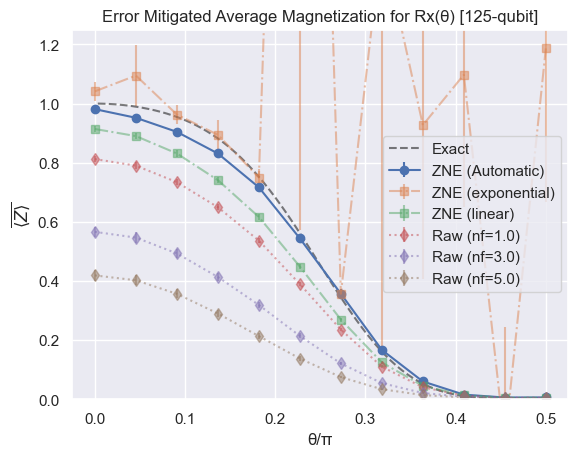

In [62]:
fig = plot_trotter_results(pub_result, parameter_values, exact=exact_data)
display(fig)

#### Plot extrapolation results for individual qubits

We also can look at extrapolation results for indivual qubits

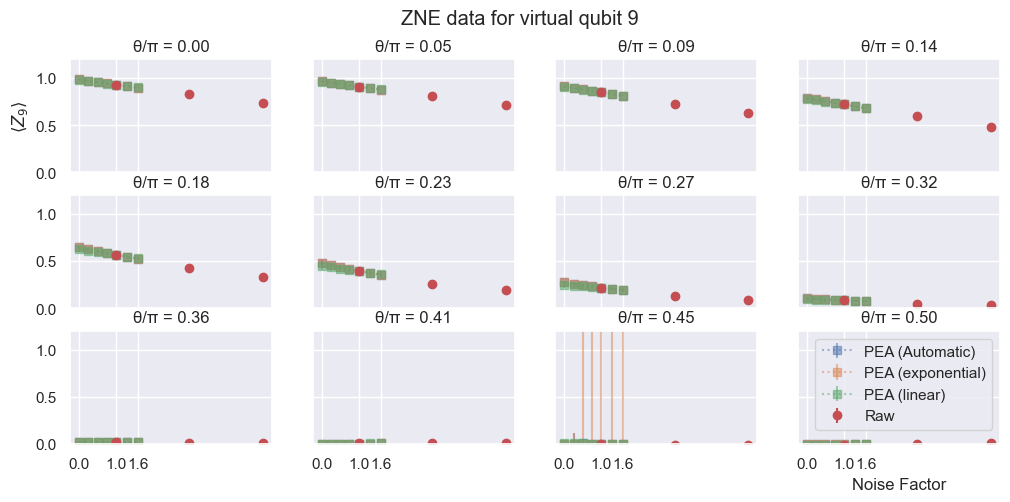

In [63]:
virtual_qubit = 9
fig = plot_qubit_zne_data(pub_result, parameter_values, virtual_qubit, num_cols=4)
display(fig)

#### General result shapes and metadata

The pub result expectation values and standard errors are array valued for all the different extrapolated values and extrapolation noise models we asked for in our Estimator options.

For the way we defined our input observables and parameter values we have:
- The first axis is the virtual qubit index for observable $\langle Z_i\rangle$
- The second axes indexes the parameter value for $\theta$
- The third axes indexes the extrapolation method in [Automatic, Exponential, Linear]
- The last axes indexes the extrapolation noise factors we computed for each model

In [64]:
# Result value shape
pub_result.data.evs.shape

(125, 12, 3, 10)

Several metadata fields are also array valued with the same shape and contain information to interpret the values. These include
- `resilience/zne_noise_factors`: The extrapolated noise factor for each result value
- `resilience/zne_extrapolator`: The extrapolator used for each result. Note that the first row of the third axis (Automatic) selects the best extrapolation result from the other values or the unextrapolated values. In our case this means it will select either Exponential, Linear or None (unextrapolated) for each qubit input observable and parameter value.

There is also resilience metadata about the learned noise models used in mitigation

In [65]:
# Plot learned layer noise metadata
for field, value in pub_result.metadata['resilience']['layer_noise'].items():
    print(f"{field}: {value}")

noise_overhead: 3.933241371460283e+66
total_mitigated_layers: 18
unique_mitigated_layers: 3
unique_mitigated_layers_noise_overhead: [419.2888240526462, 118.49135448723501, 2528862.108385179]


# Additional information

<b>Curated by:</b> Vishal Bajpe

<b>References and resources by:</b> Chris J. Wood

Version: 0.0.1a